## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

In [10]:
import numpy as np

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [11]:
def gini(sequence, weight=None):
    if weight is None: # for general decison tree
        types, counts = np.unique(sequence, return_counts=True)
        square = [np.square(c/len(sequence)) for c in counts]
    else: # for sequence with weight
        weight_sum = np.sum(weight)
        types = np.unique(sequence)
        weights = []
        # compute sum of weight in each types
        for t in types:
            weights.append(np.sum(weight[np.where(sequence==t)]))
        square = [np.square(w/weight_sum) for w in weights]
    return 1 - np.sum(square)

def entropy(sequence, weight=None):
    if weight is None: # for general decison tree
        types, counts = np.unique(sequence, return_counts=True)
        entro = [(c/len(sequence)) * np.log2(c/len(sequence)) for c in counts]
    else: # for sequence with weight
        weight_sum = np.sum(weight)
        types = np.unique(sequence)
        weights = []
        # compute sum of weights in each types
        for t in types:
            weights.append(np.sum(weight[np.where(sequence==t)]))
        entro = [(w/weight_sum) * np.log2(w/weight_sum) for w in weights]
    return -np.sum(entro)

In [4]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [5]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [6]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [12]:
import pandas as pd

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
print(train_df.shape)
print(val_df.shape)

train_df.head()

(1200, 21)
(300, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1583,1,2.1,1,11,0,14,0.7,148,7,...,942,1651,1704,17,13,2,1,0,1,1
1,745,1,0.6,1,5,0,35,0.8,102,8,...,89,1538,2459,14,1,16,1,1,0,0
2,832,0,0.7,1,2,1,39,0.7,103,4,...,125,1504,1799,5,2,11,1,0,1,0
3,1175,1,1.3,0,2,0,19,0.3,164,7,...,873,1394,1944,9,4,9,1,1,0,0
4,695,0,0.5,0,18,1,12,0.6,196,2,...,1649,1829,2855,16,13,7,1,1,1,1


In [13]:
xtrain = train_df.iloc[:, 0:20].values
ytrain = train_df['price_range'].values

xtest = val_df.iloc[:, 0:20].values
ytest = val_df['price_range'].values

columns = train_df.iloc[:, 0:20].columns

## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [14]:
class Node:
    def __init__(self, ans=None, depth=None):
        self.depth = depth # record depth of node, it must < max_depth
        self.attribute = 0 # record attribute index of node
        self.threshold = 0 # record threshold of node, and decide left or right node to be the next node
        self.left_node = None # record left node of node
        self.right_node = None # record right node of node
        self.ans = ans # record label of node

In [25]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, max_features=None):
        self.criterion = criterion
        self.max_depth = max_depth
        self.max_features = max_features # for random forest

    def fit(self, x_data, y_data, weight=None):
        self.attributes = list(range(0,x_data.shape[1])) # all the index of attributes(0 ~ 19)
        self.feature_importance = np.zeros(x_data.shape[1]) # compute feature importance 
        self.root = self.generate_tree(x_data, y_data, weight) # record the root of the tree

    def generate_tree(self, x_data, y_data, weight, depth=0):
        # which class is most of the data in 
        answers, counts = np.unique(y_data, return_counts=True)
        ans = answers[np.argmax(counts)]
        node = Node(ans, depth)
        # stop criteria:
        # 1. The data in each leaf-node belongs to the same class
        # 2. Depth of the tree is equal to max_depth
        if len(answers) > 1 and (self.max_depth is None or node.depth < self.max_depth):
            # find best attribute and best threshold
            threshold, attribute = self.split_attribute(x_data, y_data, weight)
            if attribute is not None and threshold is not None:
                attrdata = x_data[:,attribute] # all data in best attribute
                node.attribute = attribute
                node.threshold = threshold
                self.feature_importance[attribute] += 1 # raise the importance of best attribute
                # all data seperate to left data and right data 
                left_xdata = x_data[np.where(attrdata < threshold)]
                left_ydata = y_data[np.where(attrdata < threshold)]
                right_xdata = x_data[np.where(attrdata >= threshold)]
                right_ydata = y_data[np.where(attrdata >= threshold)]
                if weight is not None:
                    # in Adaboost, all weight seperate to left weight and right weight 
                    left_weight = weight[np.where(attrdata < threshold)]
                    right_weight = weight[np.where(attrdata >= threshold)]
                else:
                    left_weight = None
                    right_weight = None
                # generate left tree and right tree
                node.left_node = self.generate_tree(left_xdata, left_ydata, left_weight, depth+1)
                node.right_node = self.generate_tree(right_xdata, right_ydata, right_weight, depth+1)
        return node

    def split_attribute(self, x_data, y_data, weight):
        best_attribute = None
        best_threshold = None
        if self.criterion == 'gini':
            min_criterion = gini(y_data, weight)
        elif self.criterion == 'entropy':
            min_criterion = entropy(y_data, weight)
        # in random forest, num of attributes can be selected
        if self.max_features is not None:
            chosen_attrs = np.random.choice(self.attributes, size=self.max_features, replace=False)
        else:
            chosen_attrs = self.attributes
        # find best attribute
        for attr in chosen_attrs:
            attrdata = x_data[:,attr] # all data in this attribute
            thresholds = np.unique(attrdata) # all possible threshold in this attribute
            # find best threshold in this attribute
            for threshold in thresholds:
                # all data seperate to left data and right data
                left_ydata = y_data[np.where(attrdata < threshold)]
                right_ydata = y_data[np.where(attrdata >= threshold)]
                if weight is not None:
                    # all weight seperate to weight data and weight data
                    left_weight = weight[np.where(attrdata < threshold)]
                    right_weight = weight[np.where(attrdata >= threshold)]
                    # compute weight ratio of left node and right node
                    left_ratio = np.sum(left_weight)/np.sum(weight)
                    right_ratio = np.sum(right_weight)/np.sum(weight)
                else:
                    # without weight
                    left_weight = None
                    right_weight = None
                    # compute the proportion of the number of left node and right node
                    left_ratio = len(left_ydata)/len(attrdata)
                    right_ratio = len(right_ydata)/len(attrdata)

                if self.criterion == 'gini':
                    left_criterion = gini(left_ydata, left_weight)
                    right_criterion = gini(right_ydata, right_weight)
                elif self.criterion == 'entropy':
                    left_criterion = entropy(left_ydata, left_weight)
                    right_criterion = entropy(right_ydata, right_weight)
                # compute lm' 
                crite = left_criterion * left_ratio + right_criterion * right_ratio
                if crite < min_criterion:
                    min_criterion = crite
                    best_threshold = threshold
                    best_attribute = attr
        return best_threshold, best_attribute
        

    def predict(self, x_data):
        y_pred = []
        for i in range(len(x_data)):
            node = self.root
            # if node.left_node is None means leaf node, return the label directly 
            while node.left_node is not None: 
                if x_data[i][node.attribute] < node.threshold:
                    node = node.left_node
                else:
                    node = node.right_node
            y_pred.append(node.ans)
        y_pred = np.array(y_pred)
        return y_pred


### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [19]:
from sklearn.metrics import accuracy_score

In [12]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth10 = DecisionTree(criterion='gini', max_depth=10) # highest acc: max_depth=6

In [13]:
clf_depth3.fit(xtrain, ytrain)
ypred = clf_depth3.predict(xtest)
print("accuracy:",accuracy_score(ypred, ytest))

clf_depth10.fit(xtrain, ytrain)
ypred = clf_depth10.predict(xtest)
print("accuracy:",accuracy_score(ypred, ytest))

accuracy: 0.92
accuracy: 0.93


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [14]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_entropy = DecisionTree(criterion='entropy', max_depth=3) #highest acc: max_depth=5

In [15]:
clf_gini.fit(xtrain, ytrain)
ypred = clf_gini.predict(xtest)
print("accuracy:",accuracy_score(ypred, ytest))

clf_entropy.fit(xtrain, ytrain)
ypred = clf_entropy.predict(xtest)
print("accuracy:",accuracy_score(ypred, ytest))

accuracy: 0.92
accuracy: 0.9333333333333333


- Note: Your decisition tree scores should over **0.9**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

In [16]:
import matplotlib.pyplot as plt

<BarContainer object of 20 artists>

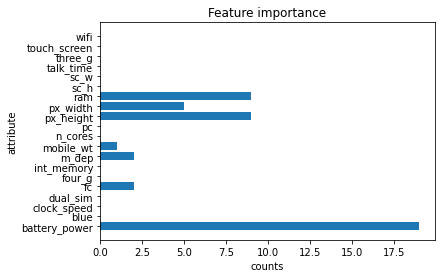

In [17]:
plt.title("Feature importance")
plt.ylabel('attribute')
plt.xlabel('counts')
plt.barh(columns, clf_depth10.feature_importance)

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [26]:
class AdaBoost():
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators # num of weak classifier
        self.weak_clfs = [] # record weak classifier
        self.alphas = [] # record alpha

    def fit(self, x_data, y_data):
        # initial weight
        w = np.ones(len(x_data))/len(x_data)
        # iterate each weak classifier
        for ind in range(self.n_estimators):
            # weak classifier is a decision tree with max_depth=1
            clf = DecisionTree(criterion="gini", max_depth=1) 
            clf.fit(x_data, y_data, weight=w) # training
            pred = clf.predict(x_data) # testing
            self.weak_clfs.append(clf)
            # if misclassified, errorList will append 1, otherwise, 0 will be added
            errorList = [int(value) for value in (pred!=y_data)]
            # sum up the weight which is misclassified 
            error = np.dot(w, errorList)
            # compute alpha
            alpha = (1/2) * np.log((1 - error)/error)
            self.alphas.append(alpha)
            # update weight
            w = np.multiply(w, np.exp([-alpha if e==0 else alpha for e in errorList]))
            w = w / np.sum(w)

    def predict(self, x_data):
        # prediction from each weak classifier
        weak_pred = np.array([clf.predict(x_data) for clf in self.weak_clfs])
        ans = np.zeros(weak_pred.shape)
        # iterate prediction from each weak classifier
        for ind in range(len(weak_pred)):
            p = np.array([wp if wp == 1 else -1 for wp in weak_pred[ind]])
            ans[ind] = self.alphas[ind] * p
        # sum up prediction in each weak classifier -> strong classifier
        sign_ans = np.sign(np.sum(ans, axis=0))
        # final prediction
        ret = np.array([1 if sa == 1 else 0 for sa in sign_ans])
        return ret

### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [27]:
ada_n10 = AdaBoost(n_estimators=10)
ada_n100 = AdaBoost(n_estimators=100)

In [28]:
ada_n10.fit(xtrain, ytrain)
ypred = ada_n10.predict(xtest)
print("accuracy:",accuracy_score(ypred, ytest))

ada_n100.fit(xtrain, ytrain)
ypred = ada_n100.predict(xtest)
print("accuracy:",accuracy_score(ypred, ytest))

accuracy: 0.95
accuracy: 0.9766666666666667


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [21]:
class RandomForest():
    def __init__(self, n_estimators, max_features, bootstrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators # num of tree
        self.max_features = int(max_features) # num of attributes can be decided
        self.bootstrap = bootstrap # boostrap samples be used or not
        self.criterion = criterion
        self.max_depth = max_depth
        self.forest = [] # record each tree

    def fit(self, x_data, y_data):
        for ind in range(self.n_estimators):
            x_inp = x_data
            y_inp = y_data
            # if bootstrap is True, random choose data to be the new training data
            if self.bootstrap is True:
                ind = np.random.choice(list(range(0,x_data.shape[0])), size=x_data.shape[0], replace=True)
                x_inp = x_data[ind]
                y_inp = y_data[ind]
            # create decision tree
            tree = DecisionTree(criterion=self.criterion, max_depth=self.max_depth, max_features=self.max_features)
            tree.fit(x_inp, y_inp)
            self.forest.append(tree)

    def predict(self, x_data):
        # prediction from each tree
        pred = np.array([tree.predict(x_data) for tree in self.forest])
        ypred = []
        # use majority votes to get the final prediction
        for ind in range(len(x_data)):
            types, counts = np.unique(pred[:, ind], return_counts=True)
            ypred.append(types[np.argmax(counts)])
        return np.array(ypred)

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [22]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(xtrain.shape[1]))
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(xtrain.shape[1]))

In [23]:
clf_10tree.fit(xtrain, ytrain)
ypred = clf_10tree.predict(xtest)
print("accuracy:",accuracy_score(ypred, ytest))

clf_100tree.fit(xtrain, ytrain)
ypred = clf_100tree.predict(xtest)
print("accuracy:",accuracy_score(ypred, ytest))

accuracy: 0.91
accuracy: 0.9433333333333334


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [24]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(xtrain.shape[1]))
clf_all_features = RandomForest(n_estimators=10, max_features=xtrain.shape[1])

In [25]:
clf_random_features.fit(xtrain, ytrain)
ypred = clf_random_features.predict(xtest)
print("accuracy:",accuracy_score(ypred, ytest))

clf_all_features.fit(xtrain, ytrain)
ypred = clf_all_features.predict(xtest)
print("accuracy:",accuracy_score(ypred, ytest))

accuracy: 0.9266666666666666
accuracy: 0.9633333333333334


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

### Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [28]:
def train_your_model(data):
    x_data = data.iloc[:, 0:20].values
    y_data = data['price_range'].values
    model = RandomForest(n_estimators=200, max_features=x_data.shape[1], max_depth=9, criterion='entropy')  
    model.fit(x_data, y_data)
    return model 

In [29]:
df1 = pd.read_csv('train.csv')
df2 = pd.read_csv('val.csv')
train_df = pd.concat([df1, df2], ignore_index=True, sort=False)

my_model = train_your_model(train_df)

In [33]:
x_test = pd.read_csv('x_test.csv').values
y_pred = my_model.predict(x_test)
np.save('y_pred.npy', y_pred)

In [31]:
assert y_pred.shape == (500, )

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [32]:
import pandas as pd
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

FileNotFoundError: [Errno 2] No such file or directory: 'y_test.csv'

In [34]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")


*** We will check your result for Question 3 manually *** (5 points)
*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 45.0 ~ 70.0
*** This score is only for reference ***
